# Install Required Packages

In [ ]:
# Install required libraries with specific versions for compatibility

%pip install numpy==1.24.4 scipy==1.10.1

# Dataset Download Using kagglehub



In [ ]:
# Download the PaySim dataset from Kaggle using kagglehub

import kagglehub
# Download latest version
path = kagglehub.dataset_download("ealaxi/paysim1")

# Loading and Preprocessing the Data

In [ ]:
import os
import pandas as pd
csv_file_path = os.path.join(path, 'PS_20174392719_1491204439457_log.csv')
df = pd.read_csv(csv_file_path)
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
print(df.head())


   step      type    amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   
3     1  CASH_OUT    181.00   C840083671           181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86   

      nameDest  oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


# Encode Categorical Column

In [ ]:
# Encode categorical 'type' column into numerical labels for ML compatibility

from sklearn.preprocessing import LabelEncoder
LabelEncoderType = LabelEncoder()
df['type'] = LabelEncoderType.fit_transform(df['type'])

# Drop Irrelevant Columns

In [ ]:
# Drop irrelevant columns (origin and destination account IDs)

df = df.drop(['nameOrig', 'nameDest'], axis=1)

# Feature and Label Separation

In [ ]:
# Separate features (X) and target label (y)

y = df['isFraud']
X = df.drop(['isFraud'], axis=1)

# Install Qiskit for Quantum ML

In [ ]:
!pip install qiskit==0.44.1 qiskit-aer==0.12.1 qiskit-algorithms==0.3.1 qiskit-machine-learning==0.7.0 qiskit_ibm_runtime pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of qiskit-ibm-runtime to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 10.7 MB/s eta 0:00:00
INFO: pip is still looking at multiple versions of qiskit-ibm-runtime to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of qiskit-ibm-provider to determine which version is compatible with other 

# Quantum Circuit Section

## Build Quantum Feature Map

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

In [ ]:
# Use only 2 features
# Ensure this matches the number of qubits in the feature map
X_small = X.iloc[:50, :2].to_numpy()
y_small = y.iloc[:50].to_numpy()

# Define the feature map with the correct number of features/qubits
# which is 2, matching X_small's dimension
feature_dimension = X_small.shape[1] # Get dimension from data
reps = 2               # Number of repetitions in ZZFeatureMap
entanglement = 'linear' # Type of entanglement between qubits

In [ ]:
# Create a custom rotation layer encoding one parameter on each qubit

training_params = ParameterVector("θ", 1)
fm0 = QuantumCircuit(feature_dimension)
for qubit in range(feature_dimension):
    fm0.ry(training_params[0], qubit)

Quantum Feature Map Circuit:


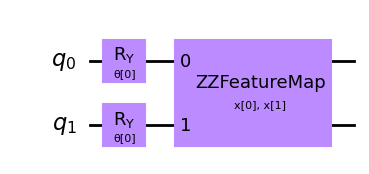

In [ ]:
from qiskit.circuit.library import ZZFeatureMap

# Standard Qiskit feature map that uses entangling ZZ rotations
fm1 = ZZFeatureMap(feature_dimension=feature_dimension, reps=reps, entanglement=entanglement)

# Compose the custom Ry rotations with the ZZFeatureMap to create final feature map
fm = fm0.compose(fm1)

print("Quantum Feature Map Circuit:")
fm.draw('mpl')  # Visualize the quantum circuit

## Simulate Quantum Circuit

In [ ]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit import transpile

# Bind all circuit parameters to a fixed value (π/4 here)
param_dict = {param: np.pi / 4 for param in fm.parameters}
bound_circuit = fm.assign_parameters(param_dict)

# Add measurement operations to all qubits for readout
bound_circuit.measure_all()

# Initialize the Aer simulator backend
simulator = AerSimulator()

# Compile the circuit for the simulator
compiled_circuit = transpile(bound_circuit, simulator)

# Run the simulation with 1024 shots (repetitions)
job = simulator.run(compiled_circuit, shots=1024)

# Retrieve results from the simulator job
result = job.result()
counts = result.get_counts()

# Print the counts of measurement outcomes as a dictionary
print("Simulation counts:", counts)

Simulation counts: {'11': 1, '01': 219, '10': 288, '00': 516}


In [ ]:
# Set up a trainable quantum kernel for SVM using fidelity

from qiskit.primitives import Sampler
sampler = Sampler()

In [ ]:
# Set up the ComputeUncompute fidelity object for quantum kernel estimation
from qiskit_algorithms.state_fidelities import ComputeUncompute

# Define fidelity object and quantum kernel

fidelity = ComputeUncompute(sampler=sampler)

In [ ]:
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC


# Build FidelityQuantumKernel
quantum_kernel = FidelityQuantumKernel(feature_map=fm1, fidelity=fidelity)

# Use QSVC
qsvc = QSVC(quantum_kernel=quantum_kernel)
qsvc.fit(X_small, y_small)
accuracy = qsvc.score(X_small, y_small)

print("QSVC accuracy:", accuracy)

QSVC accuracy: 0.96


### Preliminary Results and Reflection


1. **Quantum circuit and simulation:**
   - Constructed a quantum feature map combining custom `Ry` rotations and a `ZZFeatureMap` for entanglement.
   - Parameters were bound to π/4 and the circuit was simulated on the `AerSimulator` with 1024 shots.
   - Measurement results confirmed the circuit encodes a meaningful distribution over quantum states.

2. **Challenges faced:**
   - Adapting a large, high-dimensional dataset to a 2-qubit quantum circuit required dimensionality reduction or selective feature use.
   - Understanding and debugging Qiskit’s parameter binding and circuit composition took time.
   - This project used a simulator (`AerSimulator`) rather than real quantum hardware.